# CORD-19 text analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [2]:
# load metadata

df_meta = pd.read_csv("datasets_output/df_pub.csv",compression="gzip")
df_datasource = pd.read_csv("datasets_output/sql_tables/datasource.csv",sep="\t",header=None,names=['datasource_metadata_id', 'datasource', 'url'])
df_pub_datasource = pd.read_csv("datasets_output/sql_tables/pub_datasource.csv",sep="\t",header=None,names=['pub_id','datasource_metadata_id'])
df_cord_meta = pd.read_csv("datasets_output/sql_tables/cord19_metadata.csv",sep="\t",header=None,names=['cord19_metadata_id', 'source', 'license', 'full_text_file', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id'])

In [3]:
df_meta.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,timestamp
0,0,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020.0,NaN,Science,NaN,NaN,NaN,0.1126/science.abb7331,NaN,NaN,2020-04-04 07:55:51.892454
1,1,[Ten hot issues of breast cancer under the nov...,NaN,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,32036640.0,NaN,2020-04-04 07:55:51.892454
2,2,Another Piece of the Puzzle: Human Metapneumov...,BACKGROUND: Each winter respiratory viruses ac...,2008.0,12.0,Archives of Internal Medicine,NaN,NaN,NaN,10.1001/archinte.168.22.2489,19064834.0,PMC2783624,2020-04-04 07:55:51.892454
3,3,Viral etiology of severe pneumonia among Kenya...,CONTEXT: Pneumonia is the leading cause of chi...,2010.0,5.0,JAMA,NaN,NaN,NaN,10.1001/jama.2010.675,20501927.0,PMC2968755,2020-04-04 07:55:51.892454
4,4,Critically Ill Patients With Influenza A(H1N1)...,NaN,2014.0,4.0,JAMA,NaN,NaN,NaN,10.1001/jama.2014.2116,24566924.0,PMC6689404,2020-04-04 07:55:51.892454


In [4]:
df_meta.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'timestamp'],
      dtype='object')

In [5]:
df_datasource

,datasource_metadata_id,datasource,url
0,0,CORD19,https://pages.semanticscholar.org/coronavirus-...
1,1,Dimensions,https://docs.google.com/spreadsheets/d/1-kTZJZ...
2,2,WHO,https://www.who.int/emergencies/diseases/novel...


#### Select just CORD-19

In [6]:
df_meta = df_meta.merge(df_pub_datasource, how="inner", left_on="pub_id", right_on="pub_id")
df_meta = df_meta.merge(df_datasource, how="inner", left_on="datasource_metadata_id", right_on="datasource_metadata_id")
df_cord19 = df_meta[df_meta.datasource_metadata_id==0]
df_cord19 = df_cord19.merge(df_cord_meta, how="inner", left_on="pub_id", right_on="pub_id")

In [7]:
df_meta.shape

(56809, 16)

In [8]:
df_cord19.shape

(46994, 24)

In [9]:
df_cord19.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,...,datasource,url,cord19_metadata_id,source,license,full_text_file,ms_academic_id,who_covidence,sha,full_text
0,0,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020.0,NaN,Science,NaN,NaN,NaN,0.1126/science.abb7331,...,CORD19,https://pages.semanticscholar.org/coronavirus-...,0,WHO,unk,NaN,NaN,#8463,NaN,NaN
1,1,[Ten hot issues of breast cancer under the nov...,NaN,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,...,CORD19,https://pages.semanticscholar.org/coronavirus-...,1,WHO,unk,NaN,3.003451e+09,#615,NaN,NaN
2,2,Another Piece of the Puzzle: Human Metapneumov...,BACKGROUND: Each winter respiratory viruses ac...,2008.0,12.0,Archives of Internal Medicine,NaN,NaN,NaN,10.1001/archinte.168.22.2489,...,CORD19,https://pages.semanticscholar.org/coronavirus-...,2,PMC,unk,NaN,NaN,NaN,NaN,NaN
3,3,Viral etiology of severe pneumonia among Kenya...,CONTEXT: Pneumonia is the leading cause of chi...,2010.0,5.0,JAMA,NaN,NaN,NaN,10.1001/jama.2010.675,...,CORD19,https://pages.semanticscholar.org/coronavirus-...,3,PMC,unk,NaN,NaN,NaN,NaN,NaN
4,4,Critically Ill Patients With Influenza A(H1N1)...,NaN,2014.0,4.0,JAMA,NaN,NaN,NaN,10.1001/jama.2014.2116,...,CORD19,https://pages.semanticscholar.org/coronavirus-...,4,PMC,unk,NaN,NaN,NaN,NaN,NaN


## Text analysis

In [10]:
# TODO: add a language detection to remove all non-English

In [57]:
df_cord19[df_cord19["abstract"]==""].shape

(8349, 25)

In [11]:
# concatenate abstracts and titles

# note that ~8k articles have no abstract
df_cord19["title"] = df_cord19["title"].fillna('')
df_cord19["abstract"] = df_cord19["abstract"].fillna('')
df_cord19["title_abstract"] = df_cord19.title +" "+df_cord19.abstract

In [12]:
#texts = df_cord19[(pd.notnull(df_cord19["title_abstract"])) & (df_cord19.publication_year>2019)].title_abstract.tolist()
texts = df_cord19[(pd.notnull(df_cord19["title_abstract"]))].title_abstract.tolist()
texts[0]

'‘A ticking time bomb’: Scientists worry about coronavirus spread in Africa CAPE TOWN, SOUTH AFRICA—Late on Sunday evening, South African President Cyril Ramaphosa, in a televised address to the nation, declared that COVID-19, the respiratory disease spreading globally, had become a “national disaster.” The declaration allows his government to access special funding and instigate harsh regulations to combat the viral outbreak. “Never before in the history of our democracy have we been confronted by such a severe situation,” Ramaphosa said before announcing a raft of measures to curb the virus’ spread, including school closures, travel restrictions, and bans on large gatherings. So far, the official numbers seemed to suggest that sub-Saharan Africa, home to more than 1 billion people, had been lucky. The interactive map of reported COVID-19 cases run by Johns Hopkins University shows big red blobs almost everywhere—except sub-Saharan Africa.'

#### Topic modelling

In [13]:
from tqdm import tqdm
import gensim, sklearn
import scispacy
import spacy
import pyLDAvis.gensim

In [ ]:
!python -m spacy download en

In [14]:
#nlp = spacy.load('en')
nlp = spacy.load("en_core_sci_md")
#STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
%%time

# pre-processing: use lemmas and remove stopwords, add entities

processed_docs = list()
for doc in nlp.pipe(texts, n_process=6, batch_size=100):

    ents = doc.ents  # Named entities

    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]# token.is_alpha]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    #doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
                        
    processed_docs.append(doc)

In [ ]:
import pickle

pickle.dump(processed_docs, open("datasets_output/processed_docs_cord19_scispacy.pk", "wb"))

In [15]:
import pickle

processed_docs = pickle.load(open("datasets_output/processed_docs_cord19_scispacy.pk", "rb"))

In [16]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear several times or more). A better approach would be to use a chi_sq test.
bigram = Phrases(docs, min_count=50)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [17]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 10

In [18]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of docs: %d (%d)' % (len(corpus),len(texts)))

Number of unique tokens: 29136
Number of docs: 46994 (46994)


In [19]:
dictionary.token2id["covid-19"]

20

In [20]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 10, 'random_state': seed}
model = LdaModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 4min 42s, sys: 2.59 s, total: 4min 44s
Wall time: 4min 36s


In [21]:
model.show_topics(num_words=7, num_topics=params['num_topics'])

[(0,
  '0.017*"health" + 0.014*"disease" + 0.008*"public" + 0.008*"datum" + 0.007*"model" + 0.007*"outbreak" + 0.006*"public_health"'),
 (1,
  '0.031*"cell" + 0.018*"mouse" + 0.018*"infection" + 0.017*"response" + 0.012*"immune" + 0.010*"expression" + 0.009*"t"'),
 (2,
  '0.048*"virus" + 0.043*"cell" + 0.017*"protein" + 0.016*"viral" + 0.014*"replication" + 0.012*"infection" + 0.011*"hepatitis"'),
 (3,
  '0.019*"group" + 0.018*"=" + 0.015*"study" + 0.013*"day" + 0.013*"p" + 0.010*"high" + 0.009*"level"'),
 (4,
  '0.020*"infection" + 0.020*"dog" + 0.015*"hospital" + 0.015*"canine" + 0.014*"transmission" + 0.013*"h1n1" + 0.013*"worker"'),
 (5,
  '0.026*"calf" + 0.021*"strain" + 0.019*"isolate" + 0.017*"rotavirus" + 0.015*"bovine" + 0.014*"diarrhea" + 0.012*"sample"'),
 (6,
  '0.051*"antibody" + 0.026*"protein" + 0.025*"coronavirus" + 0.015*"s" + 0.014*"sars-cov" + 0.012*"spike" + 0.012*"pedv"'),
 (7,
  '0.025*"assay" + 0.023*"detection" + 0.017*"sample" + 0.016*"test" + 0.016*"method" + 

In [22]:
# plot topics (NOTE: the IDs here do not match those from the model)
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [23]:
# topics over time

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
topics = np.zeros((len(docs),params['num_topics']))

for n,doc_topics in enumerate(model.get_document_topics(corpus)):
    for t in doc_topics:
        topics[n][t[0]] = t[1]

In [24]:
topics[0,:]

array([0.58899075, 0.        , 0.02117411, 0.        , 0.        ,
       0.13432109, 0.03213535, 0.02725324, 0.        , 0.14957163,
       0.04038033, 0.        , 0.        , 0.        , 0.        ])

In [25]:
model.get_document_topics(corpus[0])

[(0, 0.58898634),
 (2, 0.021172175),
 (5, 0.13432088),
 (6, 0.032132164),
 (7, 0.027253347),
 (9, 0.14957902),
 (10, 0.04038254)]

In [26]:
df_topics = pd.DataFrame(topics)

In [27]:
df_topics["year"] = publication_years
df_topics["doi"] = dois

In [28]:
from_which_year = 1980

grouped = df_topics.groupby('year')
df_grouped = grouped.aggregate(np.mean)
df_grouped = df_grouped[df_grouped.index >= from_which_year]
#df_grouped

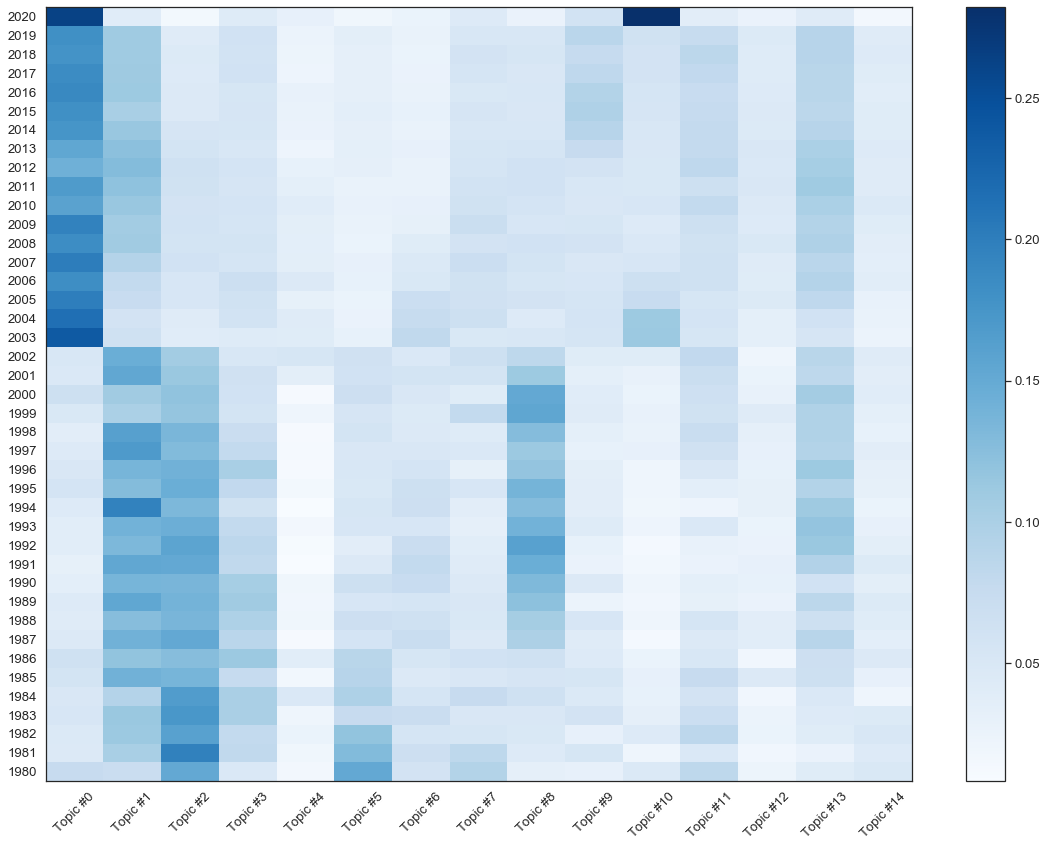

In [29]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped.index.values])
plt.xticks(np.arange(df_grouped.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(model.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/topic_model_all_time_15.pdf")
plt.show()

In [78]:
# get number of papers per topic over time

which_topic = [6,9,10]
is_selected_topic = [0 for _ in range(len(docs))]
for d in range(len(docs)):
    #d_topics = sorted(model.get_document_topics(corpus[d]), key=lambda x:x[1], reverse=True)
    d_topics = model.get_document_topics(corpus[d])
    for x in d_topics:
        if x[0] in which_topic:
            is_selected_topic[d] += x[1]
    """
    if d_topics[0][0] in which_topic:
        is_selected_topic.append(True)
    else:
        is_selected_topic.append(False)
    """

In [79]:
# plot trends

df_topic_intensity = pd.DataFrame.from_dict({"year":publication_years,"is_topic":is_selected_topic})

In [80]:
from_which_year = 1980

grouped_ti = df_topic_intensity.groupby('year')
df_grouped_ti = grouped_ti.aggregate(np.mean)
df_grouped_ti = df_grouped_ti[df_grouped_ti.index >= from_which_year]

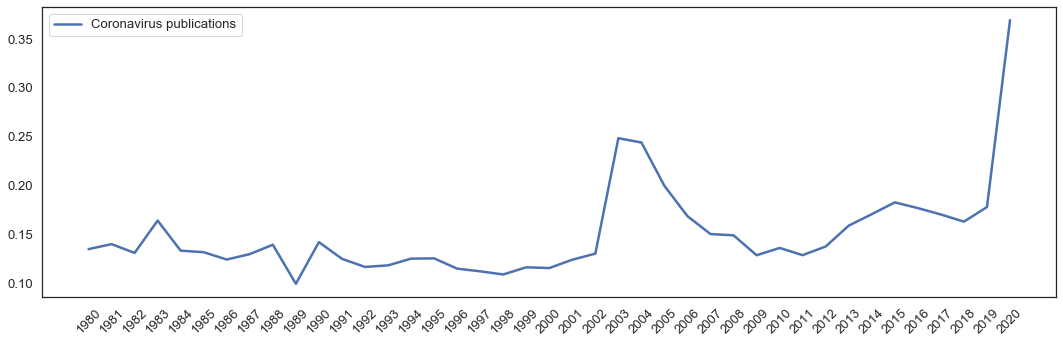

In [81]:
fig = plt.figure(figsize=(15, 5))
plt.plot(df_grouped_ti.is_topic.values, label="Coronavirus publications")
plt.xticks(np.arange(df_grouped_ti.shape[0]), [int(x) for x in df_grouped.index.values], rotation=45)
plt.legend()
plt.tight_layout()  # fixes margins
plt.savefig("figures/topic_model_coronavirus.pdf")

##### Number of topics

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.
    From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    params = {'passes': 3, 'random_state': seed}
    for num_topics in range(start, limit, step):
        m = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,# workers=6,
                passes=params['passes'], random_state=params['random_state'])
        model_list.append(m)
        coherencemodel = CoherenceModel(model=m, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run
limit=50; start=5; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Journal to topics

Using the Author topic model in gensim to map topics to journals.

In [34]:
# first, we select data for the top journals

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
journals = df_local.journal.tolist()

In [35]:
how_many = 20

journal_names = df_local.journal.value_counts().index.to_list()
journal2doc = {j:[] for j in list(set(journal_names))}

In [36]:
for n,j in enumerate(journal_names):
    journal2doc[j].append(n)

In [37]:
from gensim.models import AuthorTopicModel

params = {'num_topics': 15,'passes': 10, 'random_state': seed}
%time model_j = AuthorTopicModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary.id2token, \
                author2doc=journal2doc, chunksize=2000, passes=params['passes'], eval_every=5, \
                iterations=100, random_state=params['random_state'])

CPU times: user 57 s, sys: 550 ms, total: 57.6 s
Wall time: 40.8 s


In [38]:
model_j.show_topics(num_words=10, num_topics=params['num_topics'])

[(0,
  '0.013*"disease" + 0.007*"health" + 0.005*"model" + 0.005*"patient" + 0.005*"study" + 0.004*"datum" + 0.004*"risk" + 0.004*"SARS" + 0.004*"protein" + 0.004*"case"'),
 (1,
  '0.040*"cell" + 0.022*"virus" + 0.009*"mouse" + 0.009*"infection" + 0.008*"viral" + 0.006*"abstract" + 0.006*"culture" + 0.006*"response" + 0.005*"rat" + 0.005*"t"'),
 (2,
  '0.019*"virus" + 0.018*"cell" + 0.018*"rna" + 0.014*"protein" + 0.007*"abstract" + 0.007*"viral" + 0.006*"mrna" + 0.005*"sequence" + 0.005*"coronavirus" + 0.005*"mouse"'),
 (3,
  '0.010*"fipv" + 0.009*"feline" + 0.009*"study" + 0.008*"volume" + 0.006*"infectious" + 0.006*"human" + 0.005*"content" + 0.005*"index" + 0.005*"group" + 0.005*"chapter"'),
 (4,
  '0.011*"antibody" + 0.009*"bovine" + 0.009*"disease" + 0.007*"canine" + 0.007*"monoclonal" + 0.007*"dog" + 0.007*"infection" + 0.006*"use" + 0.005*"monoclonal_antibody" + 0.005*"bcv"'),
 (5,
  '0.009*"strain" + 0.007*"sequence" + 0.006*"p" + 0.006*"study" + 0.005*"China" + 0.005*"identif

In [39]:
model_j["PLoS ONE"]

[(1, 0.26377487722112225), (5, 0.7256559932323484)]

In [40]:
# topics over time

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
journal_names_reduced = [j for j in reversed(df_local.journal.value_counts()[:how_many].index.to_list())]
topics = np.zeros((len(journal_names_reduced),model_j.num_topics))

for n,j in enumerate(journal_names_reduced):
    for t in model_j[j]:
        topics[n][t[0]] = t[1]

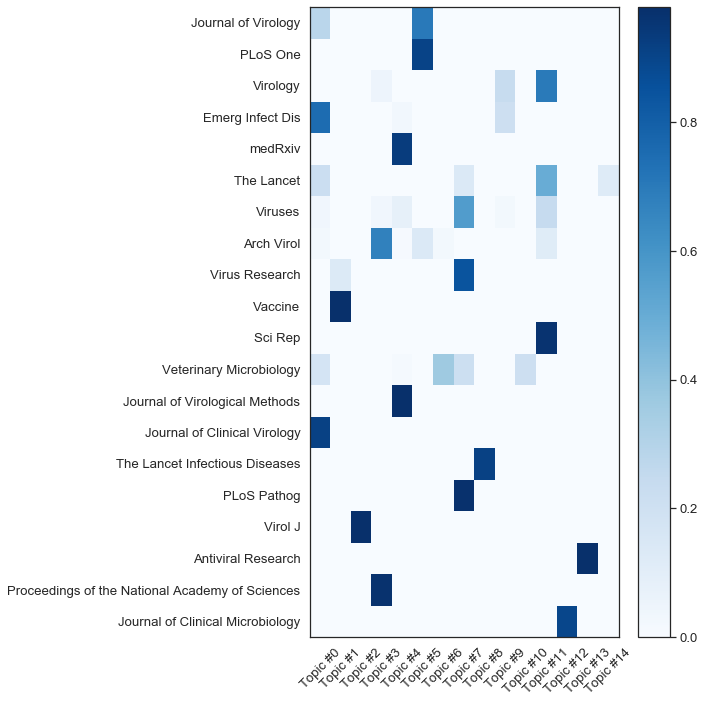

In [41]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics, norm=None, cmap='Blues')
plt.yticks(np.arange(how_many)+0.5, journal_names_reduced)
plt.xticks(np.arange(model_j.num_topics)+0.5, ["Topic #"+str(n) for n in range(model_j.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/topic_model_top_journals.pdf")
plt.show()

In [42]:
# TODO: match topics here with topics above, or directly work with the topics above for all journals

#### Correlated topic model

With tomotopy.

In [43]:
import tomotopy as tp

params = {'num_topics': 15,'passes': 10, 'random_state': seed}
mdl = tp.CTModel(k=params['num_topics'],min_cf=min_wordcount,min_df=2)
for doc in docs:
    mdl.add_doc(doc)

for i in range(0, 200, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

Iteration: 0	Log-likelihood: -8.346382399313603
Iteration: 10	Log-likelihood: -8.049614897804599
Iteration: 20	Log-likelihood: -7.861775270846221
Iteration: 30	Log-likelihood: -7.712287269309254
Iteration: 40	Log-likelihood: -7.569671492903884
Iteration: 50	Log-likelihood: -7.418755129125436
Iteration: 60	Log-likelihood: -7.266204104388067
Iteration: 70	Log-likelihood: -7.1315124964846195
Iteration: 80	Log-likelihood: -7.026582385515885
Iteration: 90	Log-likelihood: -6.943539002753201
Iteration: 100	Log-likelihood: -6.877397931369281
Iteration: 110	Log-likelihood: -6.82420183294037
Iteration: 120	Log-likelihood: -6.783903574077231
Iteration: 130	Log-likelihood: -6.755401073204129
Iteration: 140	Log-likelihood: -6.734613635074426
Iteration: 150	Log-likelihood: -6.72228827961171
Iteration: 160	Log-likelihood: -6.714758413402493
Iteration: 170	Log-likelihood: -6.711180300450649
Iteration: 180	Log-likelihood: -6.709352442026201
Iteration: 190	Log-likelihood: -6.701375375001899


In [44]:
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=7))

Top 10 words of topic #0
[('identify', 0.02288655750453472), ('severe', 0.020880186930298805), ('disease', 0.019752908498048782), ('novel', 0.017475156113505363), ('animal', 0.017168981954455376), ('syndrome', 0.01593036763370037), ('develop', 0.014276562258601189)]
Top 10 words of topic #1
[('datum', 0.02503298781812191), ('model', 0.018405042588710785), ('number', 0.017147555947303772), ('use', 0.016597861424088478), ('review', 0.016087085008621216), ('population', 0.014717713929712772), ('approach', 0.0126600107178092)]
Top 10 words of topic #2
[('infection', 0.09805650264024734), ('virus', 0.06383290141820908), ('viral', 0.06204687058925629), ('effect', 0.020593872293829918), ('role', 0.020150918513536453), ('type', 0.019906938076019287), ('level', 0.0174102820456028)]
Top 10 words of topic #3
[('protein', 0.06114864721894264), ('mouse', 0.03082796186208725), ('cell', 0.027349276468157768), ('receptor', 0.018570024520158768), ('t', 0.01584470458328724), ('domain', 0.014638119377195

In [45]:
# topics over time

topics_corr = np.zeros((len(docs),params['num_topics']))

for n,doc in enumerate(mdl.docs):
    for m,t in enumerate(doc.get_topic_dist()):
        topics_corr[n][m] = t

In [46]:
df_topics_corr = pd.DataFrame(topics_corr)

In [47]:
df_topics_corr["year"] = publication_years
df_topics_corr["doi"] = dois

In [48]:
from_which_year = 1980

grouped_corr = df_topics_corr.groupby('year')
df_grouped_corr = grouped_corr.aggregate(np.mean)
df_grouped_corr = df_grouped_corr[df_grouped_corr.index >= from_which_year]
#df_grouped

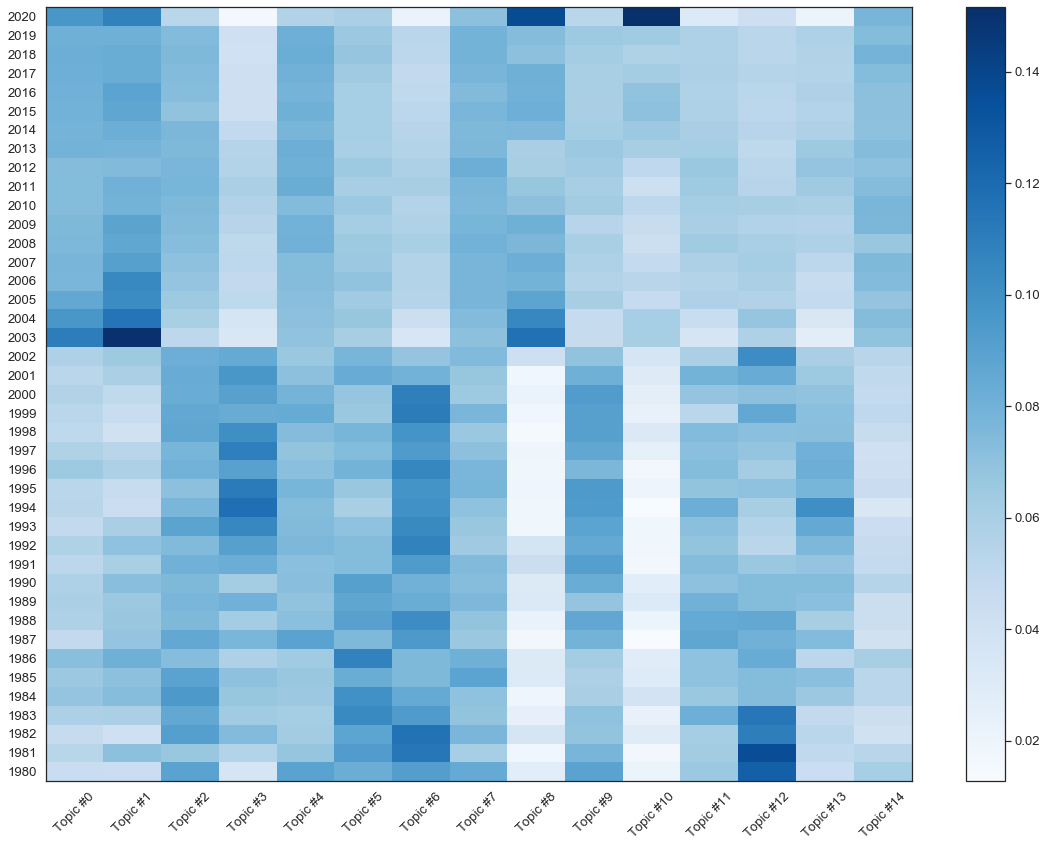

In [49]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped_corr.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped_corr.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped_corr.index.values])
plt.xticks(np.arange(df_grouped_corr.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/corr_topic_model_all_time_15.pdf")
plt.show()

In [50]:
# topic correlations

topics_correlations = np.zeros((mdl.k,mdl.k))

for k in range(mdl.k):
    for m,c in enumerate(mdl.get_correlations(k)):
        topics_correlations[k][m] = c

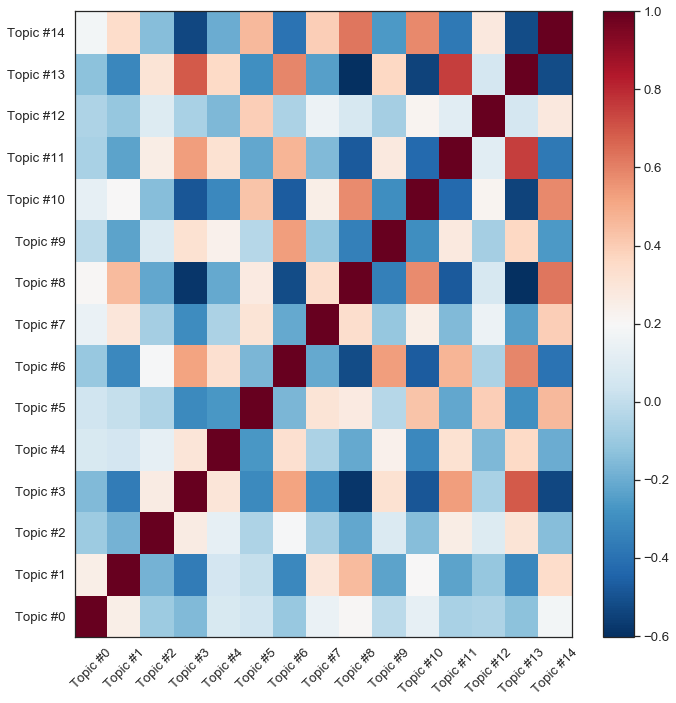

In [51]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)])
plt.xticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/corr_topic_model_correlations_15.pdf")

#### Language modelling, semantic spaces and clustering

Future work.